<a href="https://colab.research.google.com/github/nklsKrmnn/LSC_Sentiment_Analysis/blob/main/Projekt_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/LSC_Sentiment_Analysis'

Mounted at /content/drive
/content/drive/MyDrive/LSC_Sentiment_Analysis


In [2]:
import numpy as np
import seaborn as sns

try:
  import json
except:
  %pip install -q json
  import json

try:
  import logging
except:
  %pip install -q logging
  import logging

try:
  import sys
except:
  %pip install -q sys
  import sys

try:
  import os
except:
  %pip install -q os
  import os

try:
  import pandas as pd
except:
  %pip install -q pandas
  import pandas as pd

try:
  import torch
  from torch.utils.data import DataLoader
  import torch.nn as nn
  import torch.optim as optim
  from torchsummary import summary
except:
  %pip install -q torch
  import torch
  from torch.utils.data import DataLoader
  import torch.nn as nn
  import torch.optim as optim
  from torchsummary import summary

try:
  from sklearn.model_selection import train_test_split
except:
  %pip install -q sklearn
  from sklearn.model_selection import train_test_split

try:
  import transformers
  from transformers import BertTokenizer, BertModel, BertConfig
except:
  %pip install -q transformers
  import transformers
from transformers import BertTokenizer, BertModel, BertConfig


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.4 MB/s eta 0:00:00


# 1. Pre-trained BERT Model

## 1.1 Training aller Parameter

In [ ]:
from models.bert import BERTClass

In [ ]:
model = BERTClass()
model.load_state_dict(torch.load("./runs/model_saves/best_model_BERT_SM - 2023-06-28 22-08-32.387422_.pt"))
print(model)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


FileNotFoundError: ignored

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")
print(f"Number of parameters: {trainable_params}")

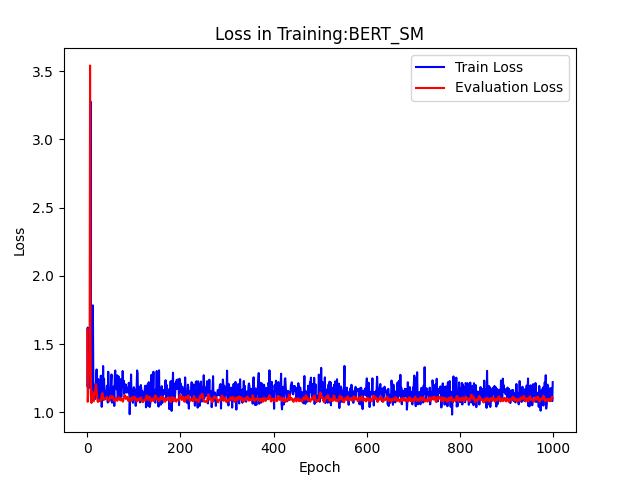

# Preprocessing BERT Layer

In [3]:
from models.bert_without_mlp import BERTClass_without_mlp
from torch import cuda
from data.datasets import dataset as dataset
from torch.utils.data import DataLoader

In [4]:
def preprocess_first_layer(path_sets, file_path):
  with torch.no_grad():
    device = 'cuda' if cuda.is_available() else 'cpu'

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BERTClass_without_mlp()
    model.to(device)

    path = os.path.join(path_sets, file_path)
    data = pd.read_csv(path, delimiter=";")
    data = data.reset_index(drop=True)

    dataset_params = {
            'onehot': True,
            'tokenize_bert': True,
            'max_len': 200,
            'tokenizer': tokenizer
        }

    dataset_tmp = dataset(data["Phrase"], data["Sentiment"], **dataset_params)


    # Dataloader initialisieren mit Datasets
    loader = DataLoader(dataset_tmp, batch_size=1)

    outputs_bert = []
    for _, batchdata in enumerate(loader):
      outputs_bert.append(model(batchdata, device).tolist()[0])

    outputs_bert = np.array(outputs_bert)
    dataset_after_first_layer = dataset(outputs_bert,
            data["Sentiment"],
            tokenize_bert=False,
            onehot=True,
            second_layer=True)
    dataset_after_first_layer[3]

    return dataset_after_first_layer

In [ ]:
path_sets = "./data/datasets_mr"
train_file = "Trainset_complete.csv"

dataset_after_first_layer = preprocess_first_layer(path_sets, train_file)
new_path = "data/dataset_mr_after_first_layer/" + "dataset_after_first_layer" + train_file.split('.')[0] + ".pt"
torch.save(dataset_after_first_layer, new_path)
print(train_file.split('.')[0] + " saved")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


onehot encoding


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
path_sets = "./data/datasets_mr"
train_file = "Trainset_complete.csv"
val_file = "Validationset.csv"

for ds in os.listdir(path_sets):
  if ("complete" not in ds):
    dataset_after_first_layer = preprocess_first_layer(path_sets, ds)
    new_path = "data/dataset_mr_after_first_layer/" + "dataset_after_first_layer" + ds.split('.')[0] + ".pt"
    torch.save(dataset_after_first_layer, new_path)
    print(ds.split('.')[0] + " saved")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


onehot encoding


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


onehot encoding
Testset saved


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, 

onehot encoding
onehot encoding
Trainset_1 saved


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, 

onehot encoding
onehot encoding
Trainset_2 saved


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, 

onehot encoding
onehot encoding
Trainset_3 saved


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, 

onehot encoding


In [ ]:
try:
  import umap
except:
  %pip install umap-learn
  import umap

from sklearn.decomposition import PCA


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=971b753f75b39860ee7e6cfbcbdfc6bcb05a0cdc87bf4ac04143e32cfe1ac45c
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=3936981f74c7947f741d9c34cb7949165ee4bf879fa9ad2cb4170aa942065641
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


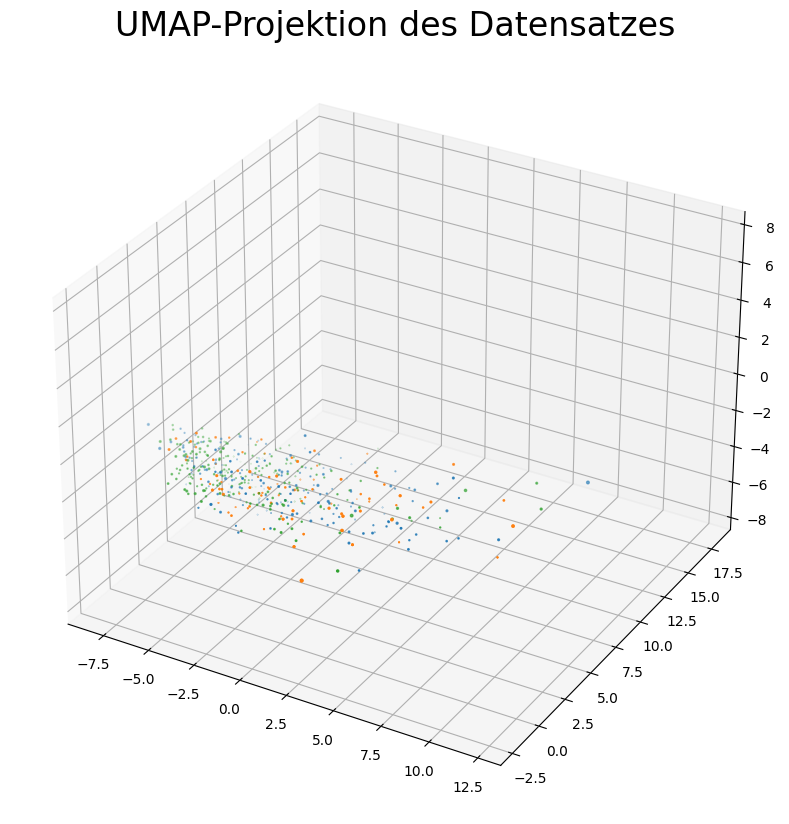

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

ds = torch.load("data/dataset_mr_after_first_layer/dataset_after_first_layerTestset.pt")

# Daten für UMAP extrahieren
input_data = [item['input'].tolist() for item in ds]
targets_data = [item['targets'] for item in ds]

# UMAP anwenden
#reducer = umap.UMAP(n_components=3, metric="manhattan")
#scaled_input_data = StandardScaler().fit_transform(input_data)
#embedding = reducer.fit_transform(input_data)

reducer = PCA(n_components=3)
embedding = reducer.fit_transform(input_data)

# Scatterplot erstellen
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    embedding[:, 2],
    c=[sns.color_palette()[torch.argmax(x)] for x in targets_data])
ax.set_ylim(top=12, bottom=4)
ax.set_xlim(auto=True)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP-Projektion des Datensatzes', fontsize=24)
plt.show()